# Project: Wrangling and Analyze Data

## Data Gathering


In [1]:
#importing all the necessary libraries that would be used in this project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import requests
import os
import re
from PIL import Image
from io import BytesIO
from bs4 import BeautifulSoup 
import json
from tweepy import OAuthHandler

%matplotlib inline

In [2]:
#Reading and storing the archived data in a dataframe
archive_df = pd.read_csv('twitter-archive-enhanced.csv')
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2. Using the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
#Programmatically downloading files from the internet - image_predictions file

folder_name = 'image_prediction'  #create folder to hold the tsv files

if not os.path.exists(folder_name): #check if the folder exists already in directory, if not create one
    os.makedirs(folder_name)

#getting image information from the given url
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)  
with open (os.path.join(folder_name, url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)

os.listdir(folder_name)

['image-predictions.tsv']

In [4]:
#Reading the image prediction file into a dataframe
img_predictions_df = pd.read_csv('image_prediction/image-predictions.tsv', sep = '\t')
img_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [5]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = archive_df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193


AttributeError: module 'tweepy' has no attribute 'TweepError'

In [6]:
#Read txt file into json format and parse into a dataframe
info_tweets = []
with open('tweet-json.txt') as json_file:
     for json_record in json_file:
        tweet = json.loads(json_record)
        tweet_id = tweet['id']
        retweets = tweet['retweet_count']
        favourites = tweet['favorite_count']
        followers = tweet['user']['followers_count']
        friends = tweet['user']['friends_count']
        info_tweets.append({'tweet_id': tweet_id, 'retweets' : retweets,
                             'favorites': favourites
                             ,
                            'friends' : friends
                             , 
                             'followers' : followers
                            })

infotweet_df = pd.DataFrame(info_tweets, columns = ['tweet_id', 'retweets', 'favorites', 'friends', 'followers'])
infotweet_df.head(5)

,tweet_id,retweets,favorites,friends,followers
0,892420643555336193,8853,39467,104,3200889
1,892177421306343426,6514,33819,104,3200889
2,891815181378084864,4328,25461,104,3200889
3,891689557279858688,8964,42908,104,3200889
4,891327558926688256,9774,41048,104,3200889


## Assessing Data
In this section, I will be assessing the three datasets that have been gathered so far to check for quality and tidyness issues.



#### Assessing the Archived Data 

In [7]:
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [8]:
archive_df.shape

(2356, 17)

In [9]:
#check for non nulls per column 
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [10]:
#Check for number of nulls per column 
archive_df.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [11]:
#check for duplicate records 
archive_df.duplicated().sum()

0

In [12]:
#Check for statistics of numerical data in the table
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [13]:
#check to see records with no rating (assuming ratings with 0 are not records with ratings)
#archive_df[archive_df.rating_numerator == 0]

In [14]:
#Check the columns in the table 
archive_df.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [15]:
#check the datatypes of the columns to ensure they are in the right datatypes
archive_df.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

In [16]:
#checking for the unique names of the dogs in the table and scanning for anomalies
archive_df.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such',
       'Maya', 'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey',
       'Lilly', 'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella',
       'Grizzwald', 'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey',
       'Gary', 'a', 'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey',
       'Duddles', 'Jack', 'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow',
       'Terrance', 'Aja', 'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict',
       'Venti', 'Goose', 'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian',
       'Walter', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover',
       'Napolean', 'Dawn', 'Boomer', 'Cody', 'Rumble', 'Clifford',
       'quite', 'Dewey', 'Scout', 'Gizmo', 'Cooper', 'Harold', 'Shikha',
       'Jamesy', 'Lili', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Nept

#### Assessing the Image Prediction Data 

In [17]:
img_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [18]:
img_predictions_df.shape

(2075, 12)

In [19]:
#check for non nulls per column 
img_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [20]:
#Check for number of nulls per column 
img_predictions_df.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [21]:
#check for duplicate records 
img_predictions_df.duplicated().sum()

0

In [22]:
#Check for statistics of numerical data in the table
img_predictions_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [23]:
#check the datatypes of the columns to ensure they are in the right datatypes
img_predictions_df.dtypes

tweet_id      int64
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

#### Assessing the tweet data 

In [24]:
infotweet_df.head()

,tweet_id,retweets,favorites,friends,followers
0,892420643555336193,8853,39467,104,3200889
1,892177421306343426,6514,33819,104,3200889
2,891815181378084864,4328,25461,104,3200889
3,891689557279858688,8964,42908,104,3200889
4,891327558926688256,9774,41048,104,3200889


In [25]:
infotweet_df.shape

(2354, 5)

In [26]:
#check for non nulls per column 
infotweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   tweet_id   2354 non-null   int64
 1   retweets   2354 non-null   int64
 2   favorites  2354 non-null   int64
 3   friends    2354 non-null   int64
 4   followers  2354 non-null   int64
dtypes: int64(5)
memory usage: 92.1 KB


In [27]:
#Check for number of nulls per column 
img_predictions_df.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [28]:
#check for duplicate records 
infotweet_df.duplicated().sum()

0

In [29]:
#Check for statistics of numerical data in the table
infotweet_df.describe()

,tweet_id,retweets,favorites,friends,followers
count,2.354000e+03,2354.000000,2354.000000,2354.0,2.354000e+03
mean,7.426978e+17,3164.797366,8080.968564,104.0,3.200942e+06
std,6.852812e+16,5284.770364,11814.771334,0.0,4.457302e+01
min,6.660209e+17,0.000000,0.000000,104.0,3.200799e+06
25%,6.783975e+17,624.500000,1415.000000,104.0,3.200898e+06
50%,7.194596e+17,1473.500000,3603.500000,104.0,3.200945e+06
75%,7.993058e+17,3652.000000,10122.250000,104.0,3.200953e+06
max,8.924206e+17,79515.000000,132810.000000,104.0,3.201018e+06


In [30]:
#check the datatypes of the columns to ensure they are in the right datatypes
infotweet_df.dtypes

tweet_id     int64
retweets     int64
favorites    int64
friends      int64
followers    int64
dtype: object

### Quality issues

Issue 1 -  Some of the records are without names and also have a zero numerator rating, these records are irrelevant to our data and to avoid skewness of data, should be removed.

Issue 2 - timestamp and retweeted_status_timestamp in archived_df table are of datatype object instead of datetime

Issue 3 - Columns which have missing values in doggo, floofer, pupper, puppo are written as None instead of NaN hence their representation seems like they have values when they don't

Issue 4 - img_prediction_df column names - p1,p2,p3 could be given better explanatory names 

Issue 5 - The archive_df table has some values in the retweet columns, which is not to be considered in this project as a user can retweet on their tweet. This means records(rows) with values in these columns will be removed.

Issue 6 - Once Issue 5 is sorted and we don't have values in the retweet columns anymore, we can remove the retweet columns as they become redundant in our analysis

Issue 7 - The rating_numerator and rating_denominator columns in archive_df table could have inconsistent values from how they were extracted, these values need to be properly extracted and replaced

Issue 8 - Records with rating denominator values not equal to 10 could be taken as inaccurate (as the ideal situation, rating_denominator = 10), and would be removed to ensure data integrity.



### Tidiness issues
Isse 1 - The columns explaining the dog stages in archive_df could have easily been merged into one to give comprehensive information on the current dogstage of that record 

Issue 2 - The three datasets currently exist in silos, we need to merge the datasets into one to have a master dataset.

## Cleaning Data


In [31]:
# Make copies of original pieces of data
archive_clean = archive_df.copy()
img_predictions_clean = img_predictions_df.copy()
infotweet_clean = infotweet_df.copy()

### Quality Issues

#### Issue 1 -  Records with no name, and zero numerator ratings

#### Define: check for the records with this, and remove them from the data 

#### Code

In [32]:
indexNames = archive_clean[(archive_clean['rating_numerator'] == 0) & (archive_clean['name'] == 'None')].index
archive_clean.drop(indexNames, inplace= True)


#### Test

In [38]:
archive_clean[(archive_clean['rating_numerator'] == 0) & (archive_clean['name'] == 'None')].count().sum()

0

#### Issue 2 - timestamp and retweeted_status_timestamp in archived_df table are of datatype object instead of datetime

#### Define: convert the datatype to a datetime using the datetime module

#### Code

In [39]:

archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'])
archive_clean['retweeted_status_timestamp'] = pd.to_datetime(archive_clean['retweeted_status_timestamp'])


#### Test

In [40]:
archive_clean.dtypes

tweet_id                                    int64
in_reply_to_status_id                     float64
in_reply_to_user_id                       float64
timestamp                     datetime64[ns, UTC]
source                                     object
text                                       object
retweeted_status_id                       float64
retweeted_status_user_id                  float64
retweeted_status_timestamp    datetime64[ns, UTC]
expanded_urls                              object
rating_numerator                            int64
rating_denominator                          int64
name                                       object
doggo                                      object
floofer                                    object
pupper                                     object
puppo                                      object
dtype: object

#### Issue 3 -  Missing values in name, doggo, floofer, pupper, puppo are written as None instead of NaN 

#### Define: convert all None values to NaN

#### Code

In [41]:
archive_clean.replace('None', np.nan, inplace=True)

#### Test

In [42]:
archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN


#### Issue 4 -  p1, p2, p3 columns in img_predictions_df could have better explanatory names 

#### Define: convert the names to standardised understable names

#### Code

In [43]:

img_predictions_clean.rename(columns = {'p1':'1st_Prediction',
                                   'p1_conf' : '1st_Prediction_Confidence',
                                   'p1_dog': '1st_Prediction_Dog',
                                   'p2': '2nd_Prediction',
                                   'p2_conf' :'2nd_Prediction_Confidence',
                                   'p2_dog': '2nd_Prediction_Dog',
                                   'p3': '3rd_Prediction',
                                   'p3_conf' :'3rd_Prediction_Confidence',
                                   'p3_dog': '3rd_Prediction_Dog'}, inplace=True)


#### Test

In [44]:
img_predictions_clean.columns

Index(['tweet_id', 'jpg_url', 'img_num', '1st_Prediction',
       '1st_Prediction_Confidence', '1st_Prediction_Dog', '2nd_Prediction',
       '2nd_Prediction_Confidence', '2nd_Prediction_Dog', '3rd_Prediction',
       '3rd_Prediction_Confidence', '3rd_Prediction_Dog'],
      dtype='object')

#### Issue 5 -  Removing rows with retweets from the archived data 

#### Define: check for the records with values in the columns retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp

#### Code

In [45]:
#take only the null values from each column in the dataset
archive_clean = archive_clean[archive_clean['retweeted_status_id'].isnull()]
archive_clean = archive_clean[archive_clean['retweeted_status_user_id'].isnull()]
archive_clean = archive_clean[archive_clean['retweeted_status_timestamp'].isnull()]

#### Test

In [46]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2173 non-null   int64              
 1   in_reply_to_status_id       77 non-null     float64            
 2   in_reply_to_user_id         77 non-null     float64            
 3   timestamp                   2173 non-null   datetime64[ns, UTC]
 4   source                      2173 non-null   object             
 5   text                        2173 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      datetime64[ns, UTC]
 9   expanded_urls               2115 non-null   object             
 10  rating_numerator            2173 non-null   int64           

Since we see that the non null values of "retweeted_status_id", "retweeted_status_user_id", and "retweeted_status_timestamp" is all 0, this satisfies the check

#### Issue 6 -  Removing the redundant retweet columns from archive data

#### Define: Identify the redundant retweet columns to drop and drop them

#### Code

In [47]:
#Dropping the columns as they are of no use to us again
archive_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

#### Test

In [48]:
archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN


#### Issue 7 - Extract the rating values properly and replace existing rating columns with new columns extracted

#### Define - Use regex to extract the rating numerator and denominator from the text column and replace existing columns with them 

#### Code

In [49]:
ratings = archive_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True).astype(float)
ratings

,0,1
0,13.0,10.0
1,13.0,10.0
2,12.0,10.0
3,13.0,10.0
4,12.0,10.0
...,...,...
2351,5.0,10.0
2352,6.0,10.0
2353,9.0,10.0
2354,7.0,10.0


In [50]:
archive_clean['rating_numerator'] = ratings[0]
archive_clean['rating_denominator'] = ratings[1]

#### Test

In [51]:
archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,NaN,NaN,NaN,NaN


#### Issue 8 -  Removing records with rating denominator values not equal to 10 (ideal value = 10)

#### Define: check for the records that fall in this category and remove them

#### Code

In [52]:
indexNames = archive_clean[archive_clean['rating_denominator'] != 10].index
archive_clean.drop(indexNames, inplace= True)

#### Test

In [53]:
#archive_clean.rating_denominator.min()
archive_clean[archive_clean['rating_denominator'] != 10].count().sum()

0

### Tidyness Issues

#### Issue 1 -  merge the dog stage columns to one 

#### Define: apply pandas method to create a column that is a concatenation of the previous dog stages and standardise the names

#### Code

In [54]:
#merging the dog stage columns into one, and delete the redundant columns
archive_clean["dog_stages"] = archive_clean["doggo"].fillna('') + archive_clean["floofer"].fillna('') + archive_clean['pupper'].fillna('') + archive_clean['puppo'].fillna('')


In [55]:
archive_clean.dog_stages.value_counts()

                1807
pupper           224
doggo             75
puppo             24
doggopupper       10
floofer            9
doggopuppo         1
doggofloofer       1
Name: dog_stages, dtype: int64

In [56]:
#correcting values like emptystring = None, doggopupper= doggo-pupper, doggofloofer = doggo-floofer, doggopuppo = doggo-puppo

previous = ['', 'doggofloofer', 'doggopupper', 'doggopuppo']
new = ['None', 'doggo-floofer', 'doggo-pupper', 'doggo-puppo']

for i in range(len(previous)):
    archive_clean['dog_stages'].replace(previous[i], new[i], inplace=True)
    
archive_clean['dog_stages'].unique()

array(['None', 'doggo', 'puppo', 'pupper', 'floofer', 'doggo-puppo',
       'doggo-floofer', 'doggo-pupper'], dtype=object)

In [57]:
#Removing the redundant stage columns
archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

In [58]:
#convert the "None" values in dog-stage column to NaN
archive_clean.replace('None', np.nan, inplace=True)

#### Test

In [59]:
archive_clean.dog_stages.value_counts()

pupper           224
doggo             75
puppo             24
doggo-pupper      10
floofer            9
doggo-puppo        1
doggo-floofer      1
Name: dog_stages, dtype: int64

In [60]:
archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,NaN


#### Issue 2 -  Merging the three tables to get the complete data in one master dataset

#### Define: merge the three tables to each other using the common column (tweet id)

#### Code

In [61]:
#create a master dataframe that holds all the informations of the three datasets on the tweet id 
#Since we want only original ratings that have retweets data and images, we use inner join 

master_df = pd.merge(archive_clean, infotweet_clean, how = 'inner', on = 'tweet_id')
master_df = pd.merge(master_df, img_predictions_clean, how = 'inner', on = 'tweet_id')
master_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,img_num,1st_Prediction,1st_Prediction_Confidence,1st_Prediction_Dog,2nd_Prediction,2nd_Prediction_Confidence,2nd_Prediction_Dog,3rd_Prediction,3rd_Prediction_Confidence,3rd_Prediction_Dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


In [62]:
master_df['source'] = master_df['source'].apply(lambda x:re.findall(r'>(.*)<', x)[0])


#### Test

In [63]:
master_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,img_num,1st_Prediction,1st_Prediction_Confidence,1st_Prediction_Dog,2nd_Prediction,2nd_Prediction_Confidence,2nd_Prediction_Dog,3rd_Prediction,3rd_Prediction_Confidence,3rd_Prediction_Dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1969,666049248165822465,NaN,NaN,2015-11-16 00:24:50+00:00,Twitter for iPhone,Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5.0,10.0,NaN,...,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
1970,666044226329800704,NaN,NaN,2015-11-16 00:04:52+00:00,Twitter for iPhone,This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6.0,10.0,a,...,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
1971,666033412701032449,NaN,NaN,2015-11-15 23:21:54+00:00,Twitter for iPhone,Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9.0,10.0,a,...,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
1972,666029285002620928,NaN,NaN,2015-11-15 23:05:30+00:00,Twitter for iPhone,This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7.0,10.0,a,...,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


#### Assessing the master dataset 

In [64]:
master_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,img_num,1st_Prediction,1st_Prediction_Confidence,1st_Prediction_Dog,2nd_Prediction,2nd_Prediction_Confidence,2nd_Prediction_Dog,3rd_Prediction,3rd_Prediction_Confidence,3rd_Prediction_Dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


In [65]:
master_df.shape

(1974, 26)

In [66]:
#check for non nulls per column 
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1974 entries, 0 to 1973
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   tweet_id                   1974 non-null   int64              
 1   in_reply_to_status_id      21 non-null     float64            
 2   in_reply_to_user_id        21 non-null     float64            
 3   timestamp                  1974 non-null   datetime64[ns, UTC]
 4   source                     1974 non-null   object             
 5   text                       1974 non-null   object             
 6   expanded_urls              1974 non-null   object             
 7   rating_numerator           1974 non-null   float64            
 8   rating_denominator         1974 non-null   float64            
 9   name                       1442 non-null   object             
 10  dog_stages                 306 non-null    object             
 11  retw

In [67]:
#Check for number of nulls per column 
master_df.isnull().sum()
#From this, we can see that the conditions that every record must have a tweet id, image, retweet is satisfied 

tweet_id                        0
in_reply_to_status_id        1953
in_reply_to_user_id          1953
timestamp                       0
source                          0
text                            0
expanded_urls                   0
rating_numerator                0
rating_denominator              0
name                          532
dog_stages                   1668
retweets                        0
favorites                       0
friends                         0
followers                       0
jpg_url                         0
img_num                         0
1st_Prediction                  0
1st_Prediction_Confidence       0
1st_Prediction_Dog              0
2nd_Prediction                  0
2nd_Prediction_Confidence       0
2nd_Prediction_Dog              0
3rd_Prediction                  0
3rd_Prediction_Confidence       0
3rd_Prediction_Dog              0
dtype: int64

In [68]:
#check for duplicate data 
master_df.duplicated().sum()

0

In [69]:
#check for duplicate tweet id - we are not meant to have the same tweet id occuring more than once in the dataset 
master_df['tweet_id'].duplicated().sum()

0

In [70]:
master_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,rating_numerator,rating_denominator,retweets,favorites,friends,followers,img_num,1st_Prediction_Confidence,2nd_Prediction_Confidence,3rd_Prediction_Confidence
count,1.974000e+03,2.100000e+01,2.100000e+01,1974.000000,1974.0,1974.000000,1974.000000,1974.0,1.974000e+03,1974.000000,1974.000000,1.974000e+03,1.974000e+03
mean,7.359660e+17,6.961213e+17,4.196984e+09,11.666049,10.0,2770.165147,8916.035461,104.0,3.200946e+06,1.202128,0.593519,1.347880e-01,6.021448e-02
std,6.763893e+16,4.424723e+16,0.000000e+00,40.842429,0.0,4685.011050,12249.372289,0.0,4.491369e+01,0.559827,0.272080,1.008040e-01,5.078309e-02
min,6.660209e+17,6.671522e+17,4.196984e+09,1.000000,10.0,16.000000,81.000000,104.0,3.200799e+06,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.757858e+17,6.717299e+17,4.196984e+09,10.000000,10.0,623.250000,1956.250000,104.0,3.200901e+06,1.000000,0.360998,5.415522e-02,1.606823e-02
50%,7.083530e+17,6.754971e+17,4.196984e+09,11.000000,10.0,1354.500000,4141.000000,104.0,3.200947e+06,1.000000,0.587440,1.181350e-01,4.952715e-02
75%,7.881228e+17,7.030419e+17,4.196984e+09,12.000000,10.0,3223.000000,11326.500000,104.0,3.201002e+06,1.000000,0.843883,1.955197e-01,9.166433e-02
max,8.924206e+17,8.558181e+17,4.196984e+09,1776.000000,10.0,79515.000000,132810.000000,104.0,3.201018e+06,4.000000,1.000000,4.880140e-01,2.710420e-01


In [71]:
master_df.dtypes

tweet_id                                   int64
in_reply_to_status_id                    float64
in_reply_to_user_id                      float64
timestamp                    datetime64[ns, UTC]
source                                    object
text                                      object
expanded_urls                             object
rating_numerator                         float64
rating_denominator                       float64
name                                      object
dog_stages                                object
retweets                                   int64
favorites                                  int64
friends                                    int64
followers                                  int64
jpg_url                                   object
img_num                                    int64
1st_Prediction                            object
1st_Prediction_Confidence                float64
1st_Prediction_Dog                          bool
2nd_Prediction      

## Storing Data

#### Observation

From this, we note that the master dataset is clean enough for analysis, we can go ahead to store out master dataset.

In [72]:
#Store master dataset to a flat file
master_df.to_csv('twitter_archive_master.csv', index= False)

In [81]:
master_df.shape

(1974, 26)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [74]:
master_df['retweets']

0       8853
1       6514
2       4328
3       8964
4       9774
        ... 
1969      41
1970     147
1971      47
1972      48
1973     532
Name: retweets, Length: 1974, dtype: int64

### Insights:
1. Which dog stage was most prominent in the data 

2. Trend of followers of Weratedogs twitter account across the period the data was collected 

3. Dog names that are most prominent in weratedogs twitter account 

### Visualization

A heat map showing the relationships between retweets, favourites, followers 

#### Insight 1

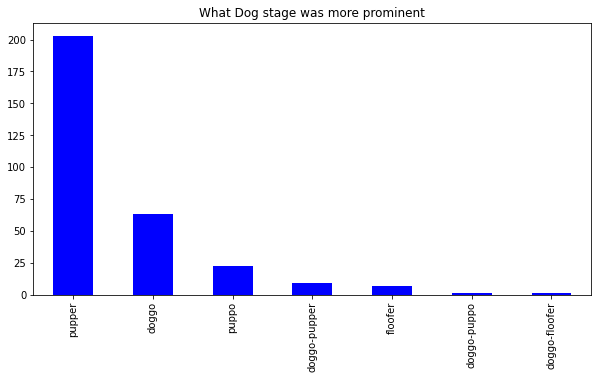

In [75]:
# Which dog stage was most prominent in the data 

chart_1 = master_df[master_df['dog_stages'] != 'None']['dog_stages'].value_counts().plot(kind='bar', color = 'b', figsize=(10,5));
plt.title('What Dog stage was more prominent');
chart_2 = chart_1.get_figure()
chart_2.savefig('dogstageplot.png')


The most prominent dog stage within the timeframe is Pupper

#### Insight 2

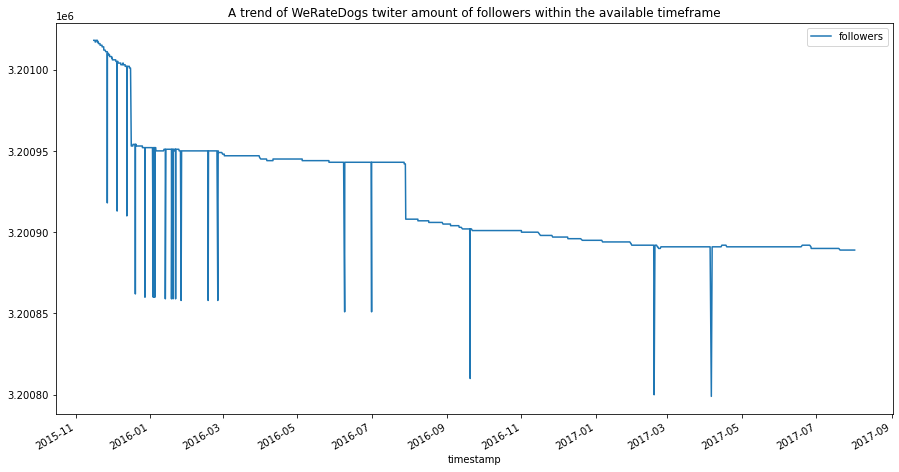

In [76]:
#Trend of followers of Weratedogs twitter account across the period the data was collected

fig_1 = master_df[['timestamp','followers']].plot('timestamp', figsize=(15,8))
plt.title('A trend of WeRateDogs twiter amount of followers within the available timeframe');
fig_2 = fig_1.get_figure()
fig_2.savefig('timetrendplot.png')


We notice a decline in the number of followers across the years - we can say number of users that followed the account increased over the period which is something that WeRateDogs will want to look at as this trend does not look good for them.

#### Insight 3

In [77]:
master_df.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stages', 'retweets', 'favorites',
       'friends', 'followers', 'jpg_url', 'img_num', '1st_Prediction',
       '1st_Prediction_Confidence', '1st_Prediction_Dog', '2nd_Prediction',
       '2nd_Prediction_Confidence', '2nd_Prediction_Dog', '3rd_Prediction',
       '3rd_Prediction_Confidence', '3rd_Prediction_Dog'],
      dtype='object')

In [78]:
# Dog names that are most prominent in weratedogs twitter account

true_1st = master_df[master_df['1st_Prediction_Dog'] == True]
true_2nd = master_df[master_df['2nd_Prediction_Dog'] == True]
true_3rd = master_df[master_df['3rd_Prediction_Dog'] == True]

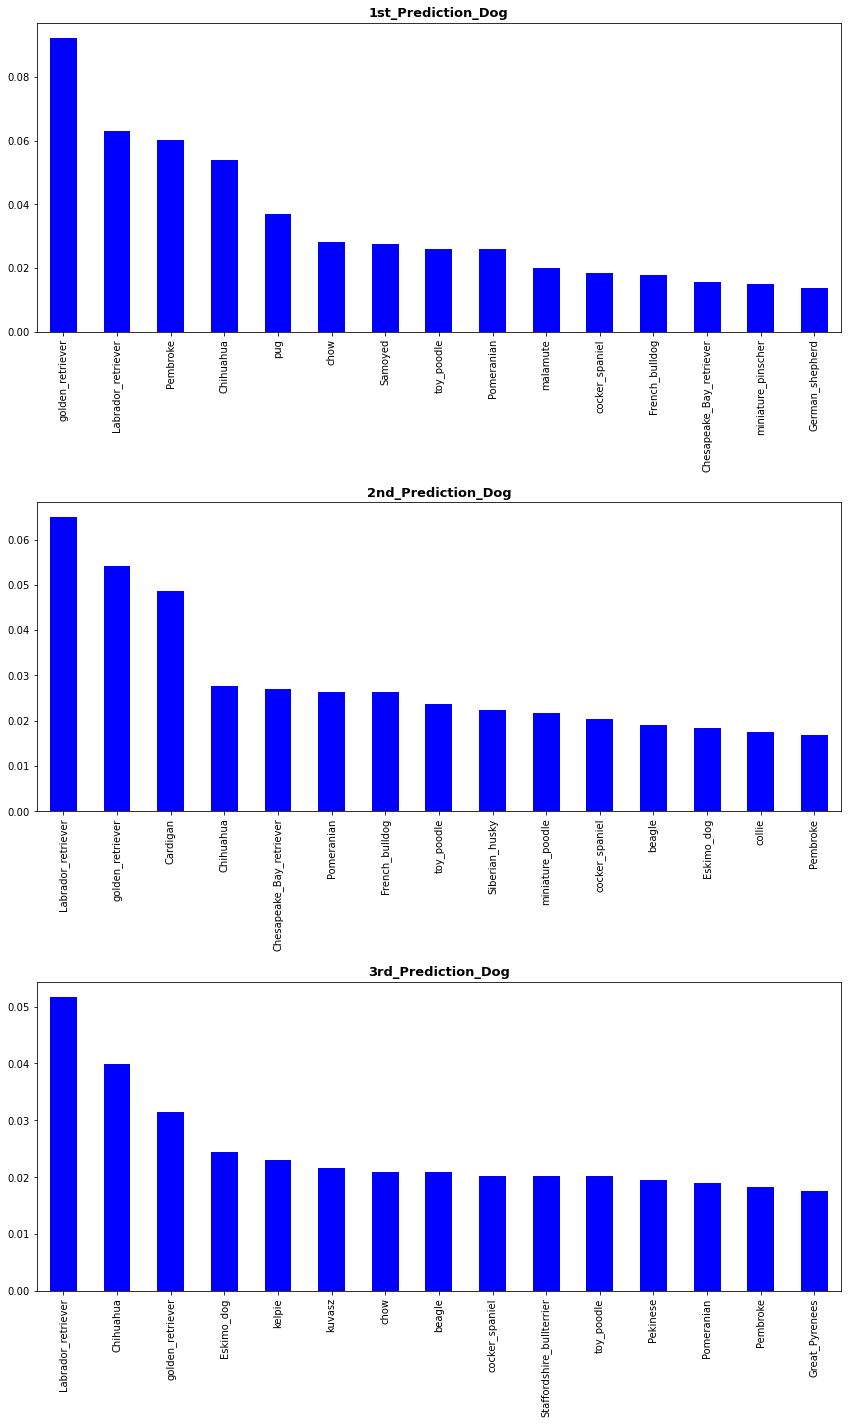

In [79]:
precision = ['1st_Prediction_Dog','2nd_Prediction_Dog', '3rd_Prediction_Dog']
dog_breed = ['1st_Prediction','2nd_Prediction','3rd_Prediction']
figure = plt.figure(figsize = [12, 20])
t = 1

for val in precision:
    plt.subplot(int(str(31)+str(t)))
    df = master_df[master_df[val] == True]
    df[dog_breed[t-1]].value_counts(normalize= True)[:15].plot.bar(color = 'b');
    plt.title(val, fontweight="bold", fontsize = 13.0)
    t+=1
    
figure.tight_layout(pad= 1.5);
figure.savefig('breedplot.png')

As seen in the above plots, we can say that golden_retriever is the most popular dog breed based on the accuracy of the first image prediction chart, while labrador_retriever is also very prominent in WeRateDogs top posts 

#### Visualization

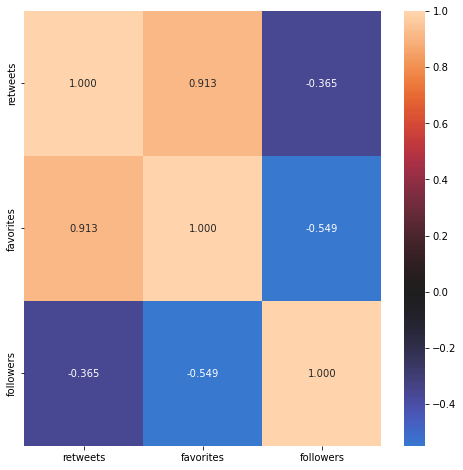

In [80]:
#A heat map showing the relationships between retweets, favourites, followers

variables = ['retweets', 'favorites', 'followers']
plt.figure(figsize=[8,8])
chart_3 = sb.heatmap(master_df[variables].corr(), annot = True, fmt = '.3f',
            center = 0);
fig_3 = chart_3.get_figure()
fig_3.savefig('heatmapplot.png')

From the above heatmap, we can deduce;

favorites and retweets have a strong positive correation, therefore the more likes we get, the more retweets of that post we are likely to get. 

followers is negatively correlated to both favourites and retweets, although followers has a weak negative correlation with retweets compared to favourites